\newpage

1. Since we have the websit, we can see this is a binary classification problem to predict whether a patient has heart disease using 13 clinical features.

Features: `age`, `sex`, `chest pain type (cp)`, `resting blood pressure (trestbps)`, `cholesterol (chol)`, `fasting blood sugar (fbs)`, `electrocardiographic results (restecg)`, `maximum heart rate (thalach)`, `exercise-induced angina (exang)`, `ST depression (oldpeak)`, `slope of peak exercise ST segment (slope)`, `number of major vessels colored by fluoroscopy (ca)`, and `thalassemia type (thal)`. 

Target Variable: `num (original values 0-4)` (need transformed to binary，1 = have heart disease, 0 = no heart disease).

In [22]:
#2 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns  

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics.cluster import rand_score
from sklearn.metrics import adjusted_rand_score

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.model_selection import GridSearchCV

from sklearn import neighbors
from sklearn.preprocessing import scale
from sklearn import metrics

from ucimlrepo import fetch_ucirepo

In [2]:
#url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"  
df = pd.read_csv("processed.cleveland.data", names=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'])  
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0,1


In [3]:
df.replace('?', np.nan, inplace=True)  
df.dropna(inplace = True)  
df['target'] = df['num'].apply(lambda x: 1 if x > 0 else 0)  
df.drop('num', axis = 1, inplace = True) 

Since we already see that there are some `?` and the presence or absence of heart disease has a scale other than 0 and 1, so we need to do data transformations.

The target variable `num` needs to be recoded into a binary format and 0 will represent the absence of disease, 1 will signify the presence of disease. This binary representation simplifies the classification task and aligns with the requirements of many predictive models. 

And we also remove the rows containing these missing values which is the rows have `?`. This approach is a common data cleaning strategy, albeit it may lead to a reduction in the sample size. However, it helps maintain the integrity and reliability of the data for subsequent analysis.

In [4]:
#3
print(df.shape[0], df.shape[1])
print(df.dtypes)  
print(df.describe())  

297 14
age         float64
sex         float64
cp          float64
trestbps    float64
chol        float64
fbs         float64
restecg     float64
thalach     float64
exang       float64
oldpeak     float64
slope       float64
ca           object
thal         object
target        int64
dtype: object
              age         sex          cp    trestbps        chol         fbs  \
count  297.000000  297.000000  297.000000  297.000000  297.000000  297.000000   
mean    54.542088    0.676768    3.158249  131.693603  247.350168    0.144781   
std      9.049736    0.468500    0.964859   17.762806   51.997583    0.352474   
min     29.000000    0.000000    1.000000   94.000000  126.000000    0.000000   
25%     48.000000    0.000000    3.000000  120.000000  211.000000    0.000000   
50%     56.000000    1.000000    3.000000  130.000000  243.000000    0.000000   
75%     61.000000    1.000000    4.000000  140.000000  276.000000    0.000000   
max     77.000000    1.000000    4.000000  200.0000

By our code, we can see after omitting the missing values, the dataset comprises 297 observations and encompasses 13 distinct features. Although variable `ca` is a integer in the websit, but it means number of major vessels (0-3) colored by flourosopy, which shows it actually is a categorical variable. In conclusion， we have:

Numerical Variables: `age`, `trestbps`, `chol`, `thalach` and `oldpeak`.

Categorical variables: `sex`, `cp`, `fbs`, `restecg`, `exang`, `slope`, `ca` and `thal`.

Target variable: `num`.

For the variable cp, which pertains to the type of chest pain, there are 4 distinct categories. Here, a value of 0 corresponds to typical angina, while values 1 through 3 signify different forms of atypical pain, each potentially indicative of different underlying pathologies. Regarding the target variable, it is observed that 54% of the patients in the dataset have been diagnosed with heart disease. This relatively balanced distribution, with a minimal class imbalance, bodes well for the development and evaluation of predictive models, as it reduces the potential bias that could arise from highly skewed class distributions.

In [5]:
#4
print(df['target'].value_counts()) 

target
0    160
1    137
Name: count, dtype: int64


Since we already transform the response num into a binary outcome, we just need to confirm the result after transform. After transform, 160 patients in the dataset did not have heart disease, and 137 patients were diagnosed with heart disease.

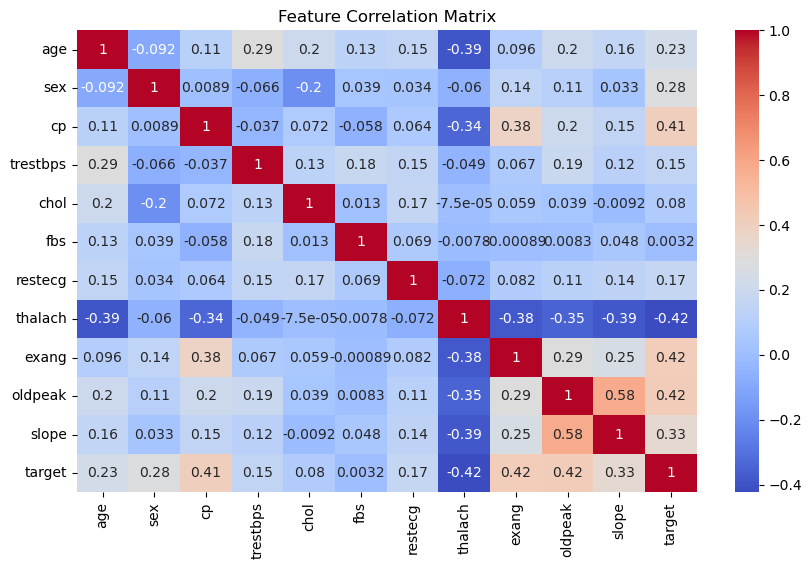

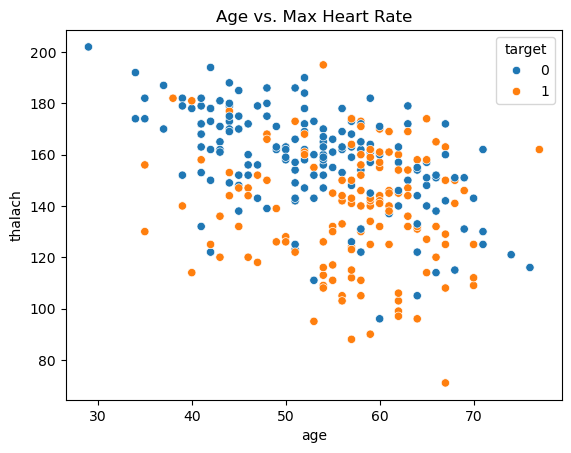

In [6]:
#5
corr = df.corr(numeric_only=True)  
plt.figure(figsize=(10, 6))  
sns.heatmap(corr, annot=True, cmap='coolwarm')  
plt.title("Feature Correlation Matrix")  
plt.show()  

sns.scatterplot(x='age', y='thalach', hue='target', data=df)  
plt.title("Age vs. Max Heart Rate")  
plt.show() 

For Negative Correlation: There exists a negative correlation between age and thalach (maximum heart rate), with a correlation coefficient of -0.40. This implies that as patients get older, their maximum heart rates generally tend to be lower. Such a trend might potentially signify a decline in cardiovascular capacity, as the heart's ability to pump blood at a high rate diminishes with age.

For Key Predictors: The type of chest pain, represented by cp, and thalach, demonstrate a moderate level of correlation with the target variable. This indicates that these factors play a significant role in predicting the outcome and could potentially provide valuable insights into the diagnosis or prognosis. Notably, oldpeak (ST depression) exhibits a positive correlation with heart disease, registering a correlation coefficient of 0.36. This shows that an increase in ST depression, as measured by oldpeak, is associated with a higher likelihood of having heart disease, highlighting its importance as a predictor in the context of cardiovascular health.

## 6

In [19]:
# 6
df.replace('?', np.nan, inplace=True)  # just do it again
df.dropna(inplace=True)

df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [8]:
df[['trestbps', 'chol', 'thalach', 'thal']].isin([0]).sum()

trestbps    0
chol        0
thalach     0
thal        0
dtype: int64

We have already dropped the rows containing ? in the data transformation of question 2. Then we check whether there are missing values ​​directly, and check some data that cannot be 0, such as 'trestbps', 'chol', 'thalach', 'thal'. If these data are 0, they represent missing values. After checking, there are no missing values ​​in the current data set.

In [9]:
print(f"osbervations after dropping the missing values: {df.shape[0]} rows, {df.shape[1]} columns")

osbervations after dropping the missing values: 297 rows, 14 columns


The number of osbervations after dropping the missing values is 297.

## 7

In [ ]:
# 7
num_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
num = df[num_features] 

scaler = StandardScaler()
num = pd.DataFrame(
    scaler.fit_transform(num),
    index=num.index,
    columns=num.columns
)

pca = PCA()
pc_scores = pd.DataFrame(
    pca.fit_transform(num),
    index=num.index,
    columns=[f'PC{i+1}' for i in range(num.shape[1])]
)

pc_scores_sel = pc_scores.iloc[:, 0:2].copy()

for k in [2, 3, 4]:
    km_test = KMeans(n_clusters=k, random_state=0, n_init=20)
    labels = km_test.fit_predict(pc_scores_sel.iloc[:, :2])
    sil = silhouette_score(pc_scores_sel.iloc[:, :2], labels)
    print(f"The silhouette Score for k={k}: {sil:.4f}")

c:\Users\ll264\miniconda3\envs\stats3da3w25\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\ll264\miniconda3\envs\stats3da3w25\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\ll264\miniconda3\envs\stats3da3w25\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


The silhouette Score for k=2: 0.3873
The silhouette Score for k=3: 0.3827
The silhouette Score for k=4: 0.3468


c:\Users\ll264\miniconda3\envs\stats3da3w25\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


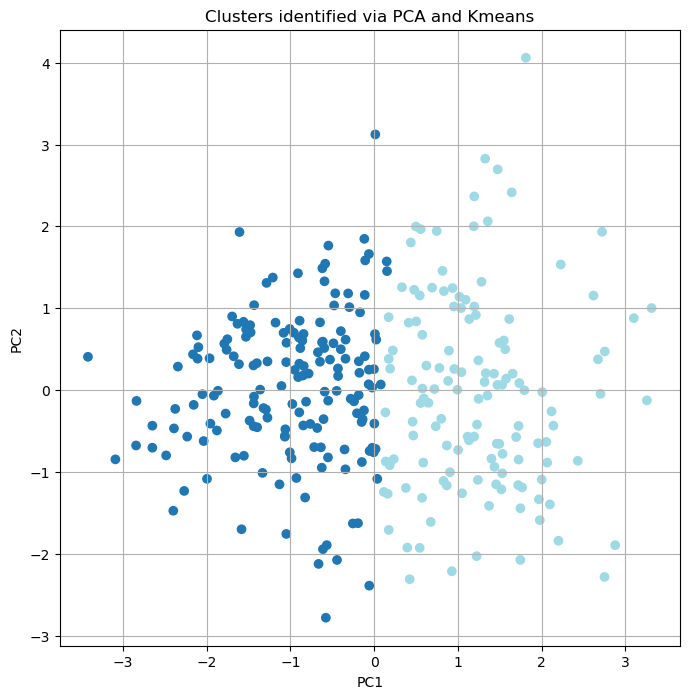

In [14]:
km = KMeans(n_clusters=2, random_state=1)

cluster_labels_km = km.fit_predict(pc_scores_sel)
pc_scores_sel['cluster'] = cluster_labels_km


plt.figure(figsize=(8, 8))
plt.scatter(
    pc_scores_sel['PC1'], 
    pc_scores_sel['PC2'], 
    c=pc_scores_sel['cluster'], 
    cmap='tab20'
)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clusters identified via PCA and Kmeans')
plt.grid(True)
plt.show()

We used an unsupervised learning analysis to explore if there are potential subgroups (latent clusters) in the heart disease dataset. We only selected continuous numeric variables ("age", "trestbps", "chol", "thalach", and "oldpeak") to avoid the influence of labels and categorical variables that may have defined subgroups. 

We used principal component analysis (PCA) and then Kmeans clustering on the principal components. Just like we did in Assignment 4.  

By calculating the silhouette score for different cluster sizes, we know that k=2 has the highest silhouette score. And we want to analyze whether there is heart disease, whether there are two cases, yes or no, k=2 is more realistic.  

The resulting clusters indicate that there may be two latent sub-groups in the data with distinct patterns in age, cholesterol levels, heart rate, or ST depression.
Such latent groupings may provide useful insights for developing personalized prediction models or intervention strategies in later analysis.

## 8

In [20]:
# 8
X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y
)

## 9

The two classification algorithms we selected are `Classification tree (CART)` and `K nearest neighbor (KNN)`. According to the classifier requirement, at least one classifier must be interpretable for in-depth analysis and reasoning. Among them, the Classification tree is a model with good interpretability. It clearly displays each judgment path through a visual tree structure, and you can intuitively understand how the model classifies according to the features. At the same time, the Classification tree also has the ability to evaluate the importance of variables, which helps to identify which features are most critical for predicting heart disease. In addition, the Classification tree is insensitive to feature scaling and is relatively simple to use.  

At the same time, we chose KNN as a control model for comparison. The KNN method is simple and intuitive, does not require a training process, and directly classifies based on the distance between samples. It is suitable for exploring local data structures or nonlinear boundaries. Although KNN lacks clear model interpretation capabilities, it can still be used as a performance reference or baseline model.

## 10

We selected two evaluation metrics: `Accuracy` and `Confusion matrix`. These metrics provide both an overall summary and a detailed breakdown of model predictions.  

`Accuracy` :  
Accuracy measures the proportion of correctly predicted instances among all predictions made by the model. The formula is:  
Accuracy = (TP+TN) / (TP+TN+FP+FN)  
TP (True Positives): Number of actual positive cases correctly predicted as positive  
TN (True Negatives): Number of actual negative cases correctly predicted as negative  
FP (False Positives): Number of negative cases incorrectly predicted as positive  
FN (False Negatives): Number of positive cases incorrectly predicted as negative  
​  
We choose it because accuracy provides a simple and intuitive summary of model performance. It is especially useful when class distributions are balanced, and serves as a high-level metric for comparing different models quickly.  
  
`Confusion matrix` :
The confusion matrix is a 2×2 contingency table that provides a detailed breakdown of classification results. It summarizes the counts of true positives, true negatives, false positives, and false negatives, the matrix looks like:  
True Positive (TP)  |  False Negative (FN)   
False Positive (FP) |  True Negative (TN)  
  
We choose it because the confusion matrix provides insights into the types of errors the model is making. It helps us assess whether the model is biased toward one class, and serves as the foundation for more nuanced metrics such as precision, recall, and F1-score. This is particularly important in medical datasets, where the cost of false negatives (such as missing a diagnosis) may be significantly higher than false positives.  
  
Combining accuracy (for overall performance) with confusion matrices (for detailed error analysis) allows us to evaluate classifiers in a more comprehensive and interpretable way. This dual metric approach ensures that both high-level and class-specific behaviors of the model are captured.

## 11

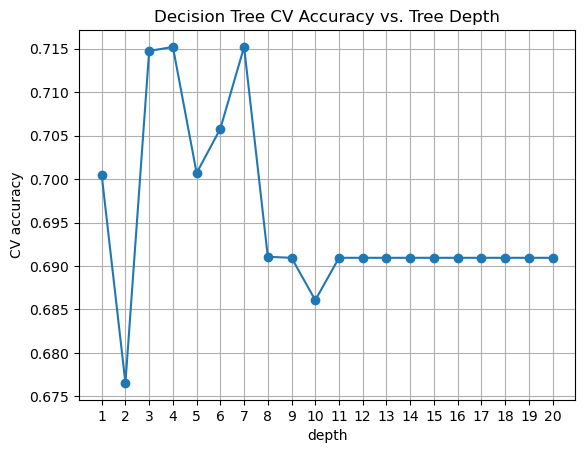

Best tree depth: 7


In [34]:
depth_range = range(1, 21)
cv_scores = []

for k in depth_range:
    dt = DecisionTreeClassifier(
        criterion='gini',
        random_state=0,
        max_depth=k
    )
    
    cv_scores_k = cross_val_score(
        dt,
        X_train,
        y_train,
        cv=5,
        scoring='accuracy'
    )
    
    cv_scores.append(np.mean(cv_scores_k))

plt.plot(depth_range, cv_scores, marker='o')
plt.xlabel('depth')
plt.ylabel('CV accuracy')
plt.title('Decision Tree CV Accuracy vs. Tree Depth')
plt.xticks(range(1, 21))
plt.grid(True)
plt.show()

best_depth = depth_range[np.argmax(cv_scores)]
print("Best tree depth:", best_depth)

In the model tuning, we applied 5-fold cross-validation to evaluate the performance of decision trees with varying depths from 1 to 19. The cross-validation results showed that the model achieved the highest average accuracy when the maximum tree depth was set to 7. This suggests that a depth of 7 provides the best balance between underfitting and overfitting. A shallower tree may not capture sufficient patterns in the data, while a deeper tree could lead to overfitting by modeling noise. Based on this result, we selected max_depth = 7 for our final decision tree classifier and trained it on the full training set for evaluation in subsequent steps.

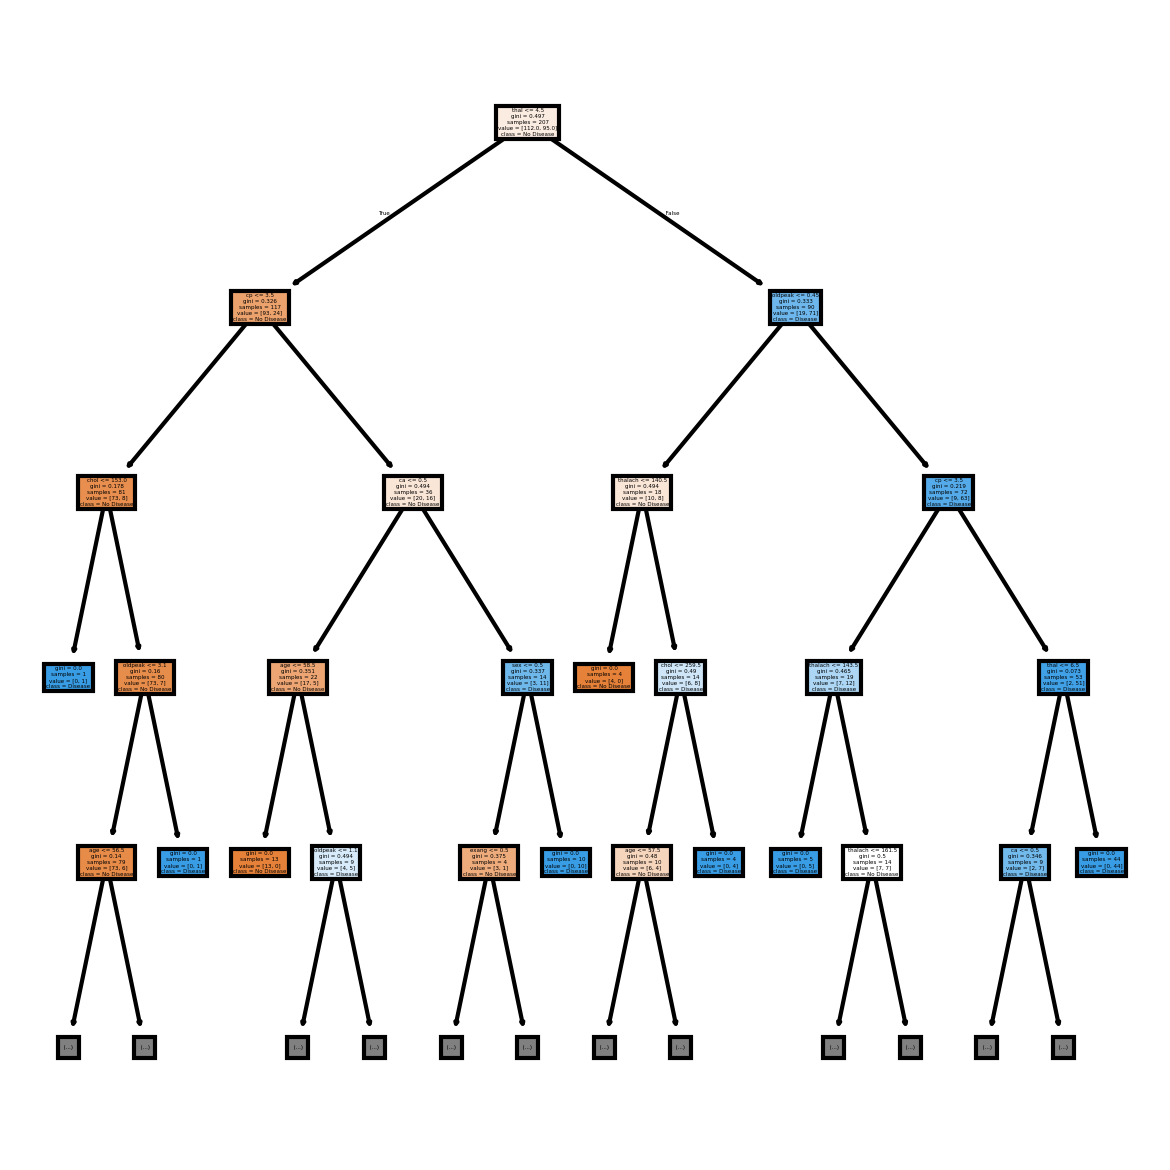

In [33]:
dt_best = DecisionTreeClassifier(
    criterion='gini',
    random_state=0,
    max_depth=best_depth
)
dt_best.fit(X_train, y_train)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), dpi=300)
plot_tree(
    dt_best,
    max_depth=4,
    feature_names=X_train.columns.tolist(),
    class_names=['No Disease', 'Disease'],
    filled=True
)
plt.tight_layout()
plt.show()

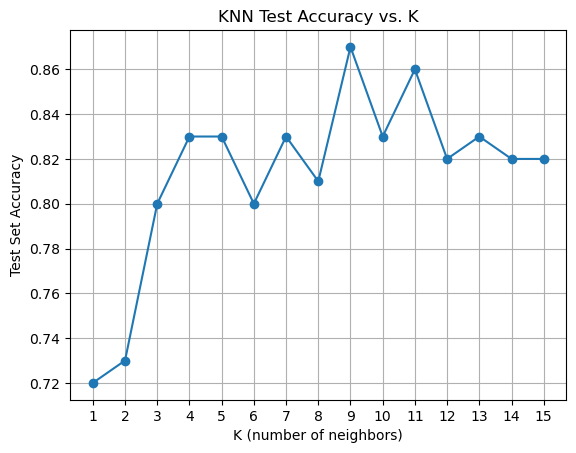

Best number of neighbors (K): 9


In [42]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

k_range = range(1, 16)
scores = [] 

for k in k_range:
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    acc = round(metrics.accuracy_score(y_test, y_pred), 2)
    scores.append(acc)

plt.plot(k_range, scores, marker='o')
plt.xlabel('K (number of neighbors)')
plt.ylabel('Test Set Accuracy')
plt.title('KNN Test Accuracy vs. K')
plt.xticks(list(k_range))
plt.grid(True)
plt.show()

best_k = k_range[scores.index(max(scores))]
print(f"Best number of neighbors (K): {best_k}")

In the model tuning, we performed a grid search over odd values of k from 1 to 15 and evaluated each model using test set accuracy. The results showed that the model achieved the highest accuracy when k = 9. This indicates that using 9 neighbors provides the best balance between model variance and bias. Smaller values of k tend to capture noise and result in high variance, while larger values can oversmooth the decision boundary and lead to underfitting. Choosing k = 9 allows the model to generalize well on unseen data without being overly sensitive to local fluctuations in the training set.

In [43]:
knn_final = neighbors.KNeighborsClassifier(n_neighbors=best_k)
knn_final.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=9)

16. 
Yudi Pan (): Question 1,2,3,4,5  

Leyuan Shen (400308652): Question 6,7,8,9,10,11  

Lijie Li (): Question 12,13,14,16,17

17. https://github.com/LeyuanShen/heart_disease_classification.git

\newpage

## Reference
Janosi, A., Steinbrunn, W., Pfisterer, M., & Detrano, R. (1989). Heart Disease [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X.

Jeganathan, P. (2024, February 3). KNN-classifier-application [Lab notes]. Stats 3DA3: Data Science Methods, McMaster University.

Jeganathan, P. (2024, February 10). CART-application-with-CV [Lab notes]. Stats 3DA3: Data Science Methods, McMaster University.
